# **Exploratory Data Analysis**

Import Packages

In [7]:
import pandas as pd
pd.set_option('display.width', 1000)

import numpy as np
import yfinance as yf

# Visualization
import matplotlib.pyplot as plt

from torchinfo import summary

from sklearn.preprocessing import StandardScaler

import joblib

import torch
import torch.nn as nn
import torch.optim as optim
import torch.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

AttributeError: module 'scipy.sparse' has no attribute 'linalg'

#--- Starting Here ---#

In [3]:
def calculate_rsi(data, window=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

In [4]:
SOXX = 'SOXX'
soxx_data = yf.download(SOXX, start='2010-01-01', end='2024-01-01')

soxx_data.reset_index(inplace=True)

soxx_data['RSI'] = calculate_rsi(soxx_data['Close'], window=14)
soxx_data['Return'] = ((soxx_data['Close'] - soxx_data['Open']) / soxx_data['Open'])
soxx_data = soxx_data[['High', 'Low', 'Volume', 'Open', 'Close', 'Return', 'RSI']]

# Normalize the data
scaler = StandardScaler()


print(len(soxx_data.columns))
soxx_data_scaled = scaler.fit_transform(soxx_data[['High', 'Low', 'Volume', 'Open', 'Close', 'Return', 'RSI']])

soxx_data_scaled = pd.DataFrame(soxx_data_scaled, columns=soxx_data.columns)
soxx_data_scaled.dropna(inplace=True)

soxx_data.dropna(inplace=True)

soxx_data.to_csv("soxxData.csv", index=False)

soxx_data_scaled.head()

[*********************100%***********************]  1 of 1 completed


NameError: name 'StandardScaler' is not defined

In [ ]:
scaler_path = "scaler.pkl"
joblib.dump(scaler, scaler_path)

# **Processing**

- create different datasets for different companies
- History sequence length: 60 days in advance
- Output sequence length: 5 days in future

Creating LSTM Dataset

In [26]:
class LSTMdataset(Dataset):
    def __init__(self, data, sequence_length, output_length):
        self.data = data
        self.data_values = self.data.values
        self.targetIDX = data.columns.get_loc('RSI')
        self.sequence_length = sequence_length
        self.output_length = output_length
        self.sample_length = sequence_length + output_length
        
        self.valid_indices = []
        for i in range(len(self.data) - self.sample_length + 1): 
            self.valid_indices.append(i)

    def __len__(self):
        return len(self.valid_indices)
    
    def __getitem__(self, idx):
        if idx >= len(self.valid_indices):
            raise IndexError("Index out of bounds")
        
        dayIDX = self.valid_indices[idx]
        
        history = self.data_values[dayIDX:dayIDX + self.sequence_length]
        forecast = self.data_values[dayIDX + self.sequence_length:dayIDX + self.sample_length, self.targetIDX]
        
        if len(history) != self.sequence_length or len(forecast) != self.output_length:
            raise ValueError(f"Inconsistent sequence length at index {idx}")

        history = torch.tensor(history, dtype=torch.float32)
        forecast = torch.tensor(forecast, dtype=torch.float32)

        return history, forecast


In [5]:
stock_loaders = {}


#-- INFO --#
shuffle = True
batch_size = 32

lstmdataset = LSTMdataset(data=soxx_data_scaled, sequence_length=60, output_length=5)

print(f"Total Length: {len(lstmdataset)}")
train_size = int(len(lstmdataset) * 0.8)
print(train_size)
test_size = int(len(lstmdataset) * 0.2)
print(test_size)
train_dataset, test_dataset = random_split(lstmdataset, lengths=[train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size, shuffle)
test_loader = DataLoader(test_dataset, batch_size, shuffle)

print(f"Combined Loader Length: {len(train_loader) + len(test_loader)}")

print(f"Train Loader Length: {len(train_loader)}")
print(f"Test Loader Length: {len(test_loader)}")

Total Length: 3445
2756
689
Combined Loader Length: 109
Train Loader Length: 87
Test Loader Length: 22


Create Model & Custom Loss Function

In [6]:
class trendLoss(nn.Module):
    def __init__(self, peak_weight):
        super(trendLoss, self).__init__()
        self.weight = peak_weight

    def forward(self, input, target):
        #print(input.shape)
        #print(target.shape)
        mse = torch.mean(torch.square(target - input))
        
        predicted_peaks = torch.argmax(input, dim=1)  
        target_peaks = torch.argmax(target, dim=1)    
        
        mismatched_peaks = (predicted_peaks != target_peaks).float()
        
        peak_penalty = mismatched_peaks.mean() * mse * self.weight

        #endpoint_loss = torch.mean(torch.square(target[2] - input[2]))

        #start_loss = torch.mean(torch.square(target[0] - input[0]))
        
        return mse + peak_penalty #+ endpoint_loss + start_loss

In [19]:
class LSTMRegression(nn.Module):
    def __init__(self, input_size, output_size):
        super(LSTMRegression, self).__init__()
        
        self.lstm1 = nn.LSTM(input_size, 128, batch_first=True)
        self.lstm2 = nn.LSTM(128, 256, batch_first=True)

        self.attention = nn.Linear(256, 1)
        self.softmax = nn.Softmax(dim=1)

        self.dense1 = nn.Linear(256, 256)  
        self.dense2 = nn.Linear(256, 128)
        self.dense3 = nn.Linear(128, output_size)
        

        self.dropout = nn.Dropout(0.3)
        
        self.relu = nn.ReLU()

    def forward(self, x):
        out, _ = self.lstm1(x)
        out, _ = self.lstm2(out)
        
        attention_scores = self.attention(out) 
        attention_weights = self.softmax(attention_scores)
        context_vector = torch.sum(out * attention_weights, dim=1) # This part in particular will ""FOCUS"" on import sequential portions
        
        out = self.dense1(context_vector)  
        out = self.relu(out) 

        out = self.dense2(out)
        out = self.relu(out)

        out = self.dense3(out)
        
        return out

Model and specifics instantiations

In [20]:
model = LSTMRegression(input_size=7, output_size=5).to(device)
optimizer = optim.Adam(params=model.parameters(), lr=1e-3)

peak_weight = torch.tensor(0.8)
customLoss = trendLoss(peak_weight)

mseLoss = nn.MSELoss()
print(model)

LSTMRegression(
  (lstm1): LSTM(7, 128, batch_first=True)
  (lstm2): LSTM(128, 256, batch_first=True)
  (dense1): Linear(in_features=256, out_features=256, bias=True)
  (dense2): Linear(in_features=256, out_features=128, bias=True)
  (dense3): Linear(in_features=128, out_features=5, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (relu): ReLU()
)


Training Portion

In [21]:
epochs = 100
model.train()
losses = []

for epoch in range(epochs):
    epoch_loss = 0.0
    batch_count = 0
    
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device).float(), labels.to(device).float()
        
        optimizer.zero_grad()

        logits = model(inputs)

        loss = customLoss(logits, torch.squeeze(labels))
        losses.append(loss.detach().cpu().numpy())
        epoch_loss += loss.item()

        batch_count += 1
        
        loss.backward()
        optimizer.step()

    avg_epoch_loss = epoch_loss / batch_count
    print(f"Epoch: {epoch}, Average Epoch Loss: {avg_epoch_loss:.4f}")



Epoch: 0, Average Epoch Loss: 0.9064
Epoch: 1, Average Epoch Loss: 0.6045
Epoch: 2, Average Epoch Loss: 0.5547
Epoch: 3, Average Epoch Loss: 0.5089
Epoch: 4, Average Epoch Loss: 0.4817
Epoch: 5, Average Epoch Loss: 0.4919
Epoch: 6, Average Epoch Loss: 0.4749
Epoch: 7, Average Epoch Loss: 0.4535
Epoch: 8, Average Epoch Loss: 0.4560
Epoch: 9, Average Epoch Loss: 0.4385
Epoch: 10, Average Epoch Loss: 0.4245
Epoch: 11, Average Epoch Loss: 0.4103
Epoch: 12, Average Epoch Loss: 0.3871
Epoch: 13, Average Epoch Loss: 0.3699
Epoch: 14, Average Epoch Loss: 0.3672
Epoch: 15, Average Epoch Loss: 0.3499
Epoch: 16, Average Epoch Loss: 0.3364
Epoch: 17, Average Epoch Loss: 0.3061
Epoch: 18, Average Epoch Loss: 0.2882
Epoch: 19, Average Epoch Loss: 0.2735
Epoch: 20, Average Epoch Loss: 0.2624
Epoch: 21, Average Epoch Loss: 0.2731
Epoch: 22, Average Epoch Loss: 0.2499
Epoch: 23, Average Epoch Loss: 0.2082
Epoch: 24, Average Epoch Loss: 0.1766
Epoch: 25, Average Epoch Loss: 0.1661
Epoch: 26, Average Epo

In [23]:
torch.save(model.state_dict(), r"predictors/model_dict")
torch.save(model, r"predictors/model")

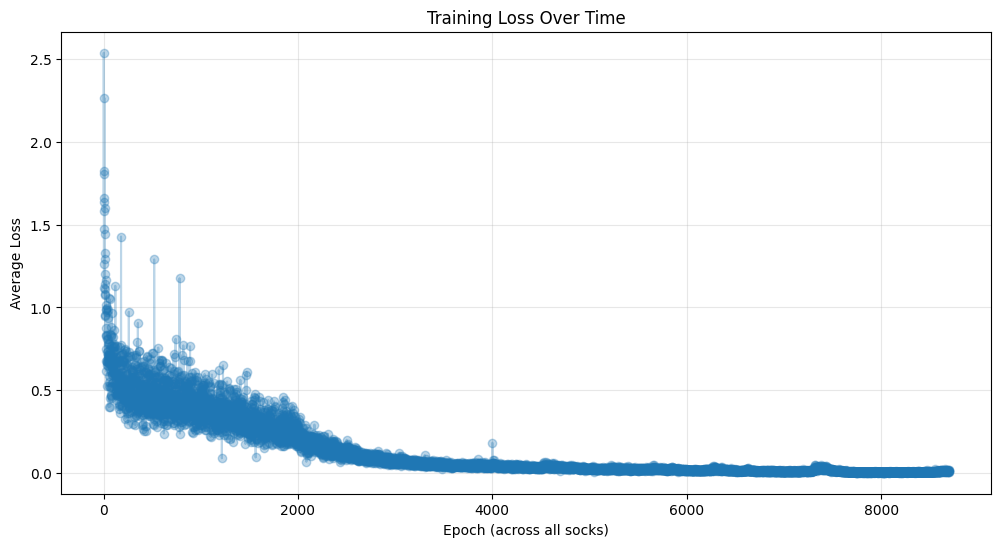

In [24]:
plt.figure(figsize=(12, 6))
xs = np.arange(len(losses))
plt.plot(xs, losses, marker='o', linestyle='-', alpha=0.3)
plt.title('Training Loss Over Time')
plt.xlabel('Epoch (across all socks)')
plt.ylabel('Average Loss')
plt.grid(True, alpha=0.3)
plt.show()

This behaviour is somewhat expected as the "Importance" of the peak penalty is higher, so it optimizes first for the mse and then later the peak penalty

(689, 5)
(689, 5)


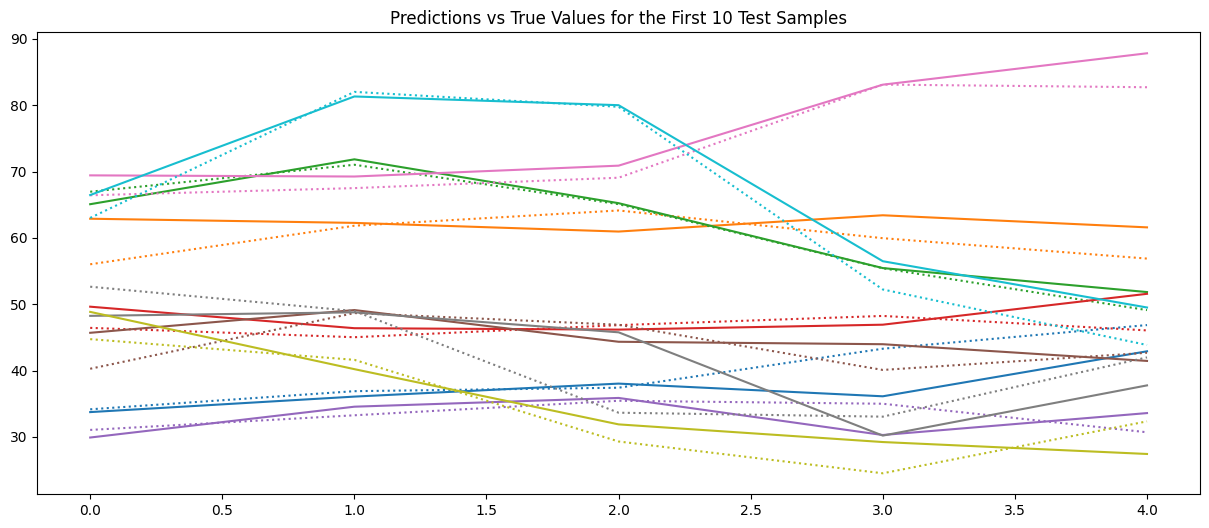

Total Loss: 91.68695068359375


In [25]:
model.eval()
predictions, true_values = [], []
loss = 0.0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device).float()
        labels = labels.to(device).float()
        outputs = model(inputs)
        test_loss = customLoss(outputs, torch.squeeze(labels))

        loss += test_loss

        predictions.append(outputs.cpu().numpy())
        true_values.append(labels.cpu().numpy())

# Convert predictions and true values to numpy arrays
predictions = np.concatenate(predictions, axis=0)
true_values = np.squeeze(np.concatenate(true_values, axis=0))

print(predictions.shape)
print(true_values.shape)

rsi_scale = scaler.scale_[6]
rsi_mean = scaler.mean_[6]

unscaled_predictions = (predictions * rsi_scale) + rsi_mean
unscaled_true_values = (true_values * rsi_scale) + rsi_mean

plt.figure(figsize=(15, 6))

default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
for i, color in enumerate(default_colors):
    plt.plot(range(5), unscaled_predictions[i], label=f"Predicted {i+1}", linestyle="-", color=color)
    plt.plot(range(5), unscaled_true_values[i], label=f"True {i+1}", linestyle=":", color=color)
plt.title('Predictions vs True Values for the First 10 Test Samples')
plt.show()

print(f"Total Loss: {loss * rsi_scale + rsi_mean}")